In [1]:
import os
import pickle
import numpy as np
import h5py
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors, BallTree, kneighbors_graph
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
from torch_geometric.data import Data, Dataset, InMemoryDataset
from torch_geometric.loader import DataLoader
from torch_geometric.utils import from_scipy_sparse_matrix
from torch_geometric.nn import SAGEConv, BatchNorm, LayerNorm, GATv2Conv, global_mean_pool, global_max_pool, GATConv, GCNConv
from torch.cuda.amp import autocast, GradScaler
from warmup_scheduler import GradualWarmupScheduler
from tqdm import tqdm
from torch_geometric.nn import GlobalAttention
from sklearn.metrics import roc_auc_score
from torch.optim.lr_scheduler import CosineAnnealingLR

h5_file = 'quark-gluon_data-set_n139306.hdf5'

with h5py.File(h5_file, 'r') as f:
    X_jets = f['X_jets'][:]  
    y = f['y'][:].astype(np.int64) 

print("X_jets shape:", X_jets.shape)
print("y shape:", y.shape)

X_jets shape: (139306, 125, 125, 3)
y shape: (139306,)


In [2]:
def split(data, batch):

    node_slice = torch.cumsum(torch.from_numpy(np.bincount(batch)), 0)
    node_slice = torch.cat([torch.tensor([0]), node_slice])
    data.__num_nodes__ = torch.bincount(batch).tolist()

    slices = {
        'x': node_slice,
        'y': torch.tensor([0], dtype=torch.long),
        'edge_index': torch.tensor([0], dtype=torch.long),
        'edge_attr': torch.tensor([0], dtype=torch.long)
    }

    if data.y is not None:
        if data.y.size(0) == batch.size(0):
            slices['y'] = node_slice
        else:
            slices['y'] = torch.arange(0, batch[-1] + 2, dtype=torch.long)

    return data, slices

scaler_ecal = StandardScaler()
scaler_hcal = StandardScaler()
scaler_tracks = StandardScaler()

def fit_global_scalers(X_jets):

    global scaler_ecal, scaler_hcal, scaler_tracks
    
    all_points = []

    for img in tqdm(X_jets):
        mask = np.any(img > 1e-3, axis=2) 
        y_coords, x_coords = np.nonzero(mask)  
        
        if len(y_coords) > 0:  
            all_points.append(img[y_coords, x_coords, :])  

    all_points = np.vstack(all_points)

    scaler_ecal.fit(all_points[:, 0].reshape(-1, 1))
    scaler_hcal.fit(all_points[:, 1].reshape(-1, 1))
    scaler_tracks.fit(all_points[:, 2].reshape(-1, 1))
    
    print("Global scalers fitted!")

def normalize_point_cloud(points):

    points_norm = np.copy(points)
    points_norm[:, 0] = scaler_ecal.transform(points[:, 0].reshape(-1, 1)).flatten()
    points_norm[:, 1] = scaler_hcal.transform(points[:, 1].reshape(-1, 1)).flatten()
    points_norm[:, 2] = scaler_tracks.transform(points[:, 2].reshape(-1, 1)).flatten()
    return points_norm

def image_to_point_cloud(image):
    mask = np.sum(image, axis=2) > 0 
    y_coords, x_coords = np.nonzero(mask) 
    features = image[y_coords, x_coords, :] 
    points = np.hstack((features, x_coords[:, None], y_coords[:, None]))  
    points = normalize_point_cloud(points)  

    return points.astype(np.float32)

def point_cloud_to_graph(points, k=5):

    num_nodes = points.shape[0]

    k_eff = max(2, min(k + 1, num_nodes))

    tree = BallTree(points[:, -2:])  
    distances, indices = tree.query(points[:, -2:], k=k_eff)

    neighbors = indices[:, 1:] 
    
    delta_features = points[neighbors, :-2] - points[:, None, :-2]
    delta_features = delta_features.reshape(-1, 3)

    dist_vals = distances[:, 1:].reshape(-1, 1)  

    edge_attr = np.hstack((dist_vals, delta_features)).astype(np.float32)

    source_nodes = np.repeat(np.arange(num_nodes), k_eff - 1) 
    edge_index = np.stack((source_nodes, neighbors.reshape(-1)), axis=0).astype(np.int32)

    return points, edge_index, edge_attr

def read_graph(X_jets, y, k=5):

    x_list = []
    edge_index_list = []
    edge_attr_list = []
    node_graph_id_list = []
    y_list = []

    num_nodes_list = []
    num_edges_list = []

    for img_idx, img in enumerate(tqdm(X_jets)):
        points = image_to_point_cloud(img)

        vertices, img_edge_index, img_edge_attr = point_cloud_to_graph(points, k=k)
        x_list.append(vertices)
        edge_index_list.append(img_edge_index)
        edge_attr_list.append(img_edge_attr)
        node_graph_id_list.append(np.full(vertices.shape[0], img_idx, dtype=np.int32))
        y_list.append(y[img_idx].reshape(1, -1))

        num_nodes_list.append(vertices.shape[0])
        num_edges_list.append(img_edge_index.shape[1])

    x = np.vstack(x_list) 
    edge_index = np.hstack(edge_index_list) 
    edge_attr = np.vstack(edge_attr_list)  
    node_graph_id = np.concatenate(node_graph_id_list) 
    y_data = np.vstack(y_list) 

    x = torch.from_numpy(x).to(torch.float32).pin_memory()
    edge_index = torch.from_numpy(edge_index).to(torch.int64).pin_memory()
    edge_attr = torch.from_numpy(edge_attr).to(torch.float32).pin_memory()
    y_data = torch.from_numpy(y_data).to(torch.float32).pin_memory()
    node_graph_id = torch.from_numpy(node_graph_id).to(torch.int64).pin_memory()

    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y_data)
    
    data, slices = split(data, node_graph_id)

    edge_slice = np.concatenate(([0], np.cumsum(num_edges_list)))  
    slices['edge_index'] = torch.from_numpy(edge_slice).to(torch.int32)
    slices['edge_attr'] = torch.from_numpy(edge_slice).to(torch.int32)

    return data, slices


In [3]:
graph_file = "jet_graphs.pkl"

if os.path.exists(graph_file):
    with open(graph_file, "rb") as f:
        data, slices = pickle.load(f)
    print("Loaded preprocessed graphs from file!")
else:   
    fit_global_scalers(X_jets)
    data, slices = read_graph(X_jets, y, k=5)
    
    with open(graph_file, "wb") as f:
        pickle.dump((data, slices), f)
    print("Graph dataset processed and saved!")

Loaded preprocessed graphs from file!


In [4]:
class JetGraphDataset(InMemoryDataset):
    def __init__(self, graph_file, transform=None, pre_transform=None):
        super(JetGraphDataset, self).__init__(None, transform, pre_transform)
    
        if os.path.exists(graph_file):
            with open(graph_file, "rb") as f:
                loaded = pickle.load(f)
            
            assert isinstance(loaded, tuple) and len(loaded) == 2
            
            self.data, self.slices = loaded 

    def len(self):
        assert self.slices is not None
        return len(self.slices['x']) - 1 

dataset = JetGraphDataset(graph_file=graph_file)

train_idx, test_idx = train_test_split(
    np.arange(len(dataset)), test_size=0.2, stratify=dataset.data.y.numpy()
)
train_idx, val_idx = train_test_split(
    train_idx, test_size=0.125, stratify=dataset.data.y.numpy()[train_idx]
)

train_dataset = dataset[train_idx]
val_dataset = dataset[val_idx]
test_dataset = dataset[test_idx]

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True) #64
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

for batch in train_loader:
    print(f"Batch x shape: {batch.x.shape}")
    print(f"Batch edge_index shape: {batch.edge_index.shape}")
    print(f"Batch y shape: {batch.y.shape}")
    break 

/beegfs/home/anning/.conda/envs/qenv/lib/python3.10/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/beegfs/home/anning/.conda/envs/qenv/lib/python3.10/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Batch x shape: torch.Size([21777, 5])
Batch edge_index shape: torch.Size([2, 108885])
Batch y shape: torch.Size([32, 1])


In [5]:
class GCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes, dropout=0.5):
        super(GCN, self).__init__()
        self.gcn1 = GCNConv(in_channels, hidden_channels)
        self.gcn2 = GCNConv(hidden_channels, hidden_channels)
        self.fc = nn.Linear(hidden_channels, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.gcn1(x, edge_index))
        x = self.dropout(x)
        x = F.relu(self.gcn2(x, edge_index))
        x = self.dropout(x)
        x = global_mean_pool(x, data.batch)
        x = self.fc(x)
        return x

class Hybrid_GATv2_GCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes, heads=[8, 6, 6], dropout=0.5):
        super(Hybrid_GATv2_GCN, self).__init__()

        self.gat1 = GATv2Conv(in_channels, hidden_channels, heads=heads[0], dropout=dropout)
        self.bn1 = LayerNorm(hidden_channels * heads[0])

        self.gat2 = GATv2Conv(hidden_channels * heads[0], hidden_channels, heads=heads[1], dropout=dropout)
        self.bn2 = LayerNorm(hidden_channels * heads[1])

        self.gcn = GCNConv(hidden_channels * heads[1], hidden_channels)
        self.bn3 = LayerNorm(hidden_channels)

        self.gat3 = GATv2Conv(hidden_channels, hidden_channels, heads=heads[2], dropout=dropout)
        self.bn4 = LayerNorm(hidden_channels * heads[2])

        self.fc = nn.Linear(hidden_channels * heads[2], num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        x = self.gat1(x, edge_index)
        x = self.bn1(x)
        x = F.elu(x)

        x = self.gat2(x, edge_index)
        x = self.bn2(x)
        x = F.elu(x)

        x = self.gcn(x, edge_index)
        x = self.bn3(x)
        x = F.elu(x)

        x = self.gat3(x, edge_index)
        x = self.bn4(x)
        x = F.elu(x)

        x = global_mean_pool(x, data.batch)
        x = self.dropout(x)
        x = self.fc(x)

        return x

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
in_channels = dataset.data.x.shape[1]
hidden_channels = 128
num_classes = len(torch.unique(dataset.data.y))

baseline_model = GCN(in_channels, hidden_channels, num_classes).to(device)
hybrid_model = Hybrid_GATv2_GCN(in_channels, hidden_channels, num_classes).to(device)

optimizer_baseline = torch.optim.Adam(baseline_model.parameters(), lr=1e-3, weight_decay=5e-5)
optimizer_hybrid = torch.optim.Adam(hybrid_model.parameters(), lr=1e-3, weight_decay=5e-5)
scheduler_baseline = CosineAnnealingLR(optimizer_baseline, T_max=50, eta_min=1e-5)
scheduler_hybrid = CosineAnnealingLR(optimizer_hybrid, T_max=50, eta_min=1e-5)
criterion = nn.CrossEntropyLoss()

/beegfs/home/anning/.conda/envs/qenv/lib/python3.10/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


In [7]:
def train(model, optimizer, train_loader):
    model.train()
    total_loss, correct, total = 0, 0, 0
    scaler = GradScaler()

    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        with autocast():
            out = model(data)
            loss = criterion(out, data.y.view(-1).long())
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        pred = out.argmax(dim=1)
        correct += (pred == data.y.view(-1)).sum().item()
        total += data.y.size(0)

    return total_loss / len(train_loader), correct / total


def evaluate(model, loader):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data)
            loss = criterion(out, data.y.view(-1).long())
            total_loss += loss.item()

            pred = out.argmax(dim=1)
            correct += (pred == data.y.view(-1)).sum().item()
            total += data.y.size(0)

            all_preds.append(F.softmax(out, dim=1)[:, 1].cpu().numpy()) 
            all_labels.append(data.y.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    roc_auc = roc_auc_score(all_labels, all_preds)

    return total_loss / len(loader), correct / total, roc_auc

Epoch 1/50, GCN - AUC: 0.7362 | Hybrid GATv2-GCN - AUC: 0.7341
Epoch 2/50, GCN - AUC: 0.7468 | Hybrid GATv2-GCN - AUC: 0.7521
Epoch 3/50, GCN - AUC: 0.7476 | Hybrid GATv2-GCN - AUC: 0.7552
Epoch 4/50, GCN - AUC: 0.7455 | Hybrid GATv2-GCN - AUC: 0.7490
Epoch 5/50, GCN - AUC: 0.7469 | Hybrid GATv2-GCN - AUC: 0.7566
Epoch 6/50, GCN - AUC: 0.7482 | Hybrid GATv2-GCN - AUC: 0.7580
Epoch 7/50, GCN - AUC: 0.7496 | Hybrid GATv2-GCN - AUC: 0.7594
Epoch 8/50, GCN - AUC: 0.7479 | Hybrid GATv2-GCN - AUC: 0.7542
Epoch 9/50, GCN - AUC: 0.7512 | Hybrid GATv2-GCN - AUC: 0.7602
Epoch 10/50, GCN - AUC: 0.7491 | Hybrid GATv2-GCN - AUC: 0.7613
Epoch 11/50, GCN - AUC: 0.7515 | Hybrid GATv2-GCN - AUC: 0.7614
Epoch 12/50, GCN - AUC: 0.7509 | Hybrid GATv2-GCN - AUC: 0.7613
Epoch 13/50, GCN - AUC: 0.7519 | Hybrid GATv2-GCN - AUC: 0.7587
Epoch 14/50, GCN - AUC: 0.7524 | Hybrid GATv2-GCN - AUC: 0.7613
Epoch 15/50, GCN - AUC: 0.7527 | Hybrid GATv2-GCN - AUC: 0.7570
Epoch 16/50, GCN - AUC: 0.7506 | Hybrid GATv2-GCN

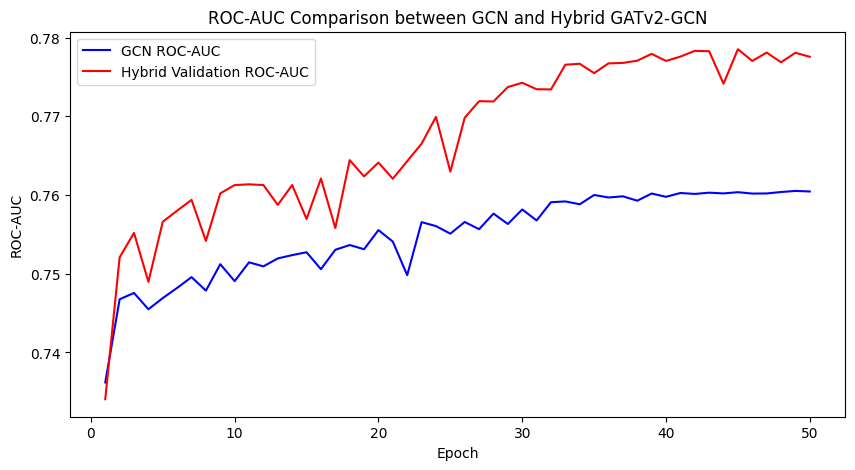


Final Test ROC-AUC - GCN: 0.7556, Hybrid GATv2-GCN: 0.7724


In [8]:
num_epochs = 50
val_aucs_baseline, val_aucs_hybrid = [], []

for epoch in range(num_epochs):
    train(baseline_model, optimizer_baseline, train_loader)
    train(hybrid_model, optimizer_hybrid, train_loader)

    val_loss_baseline, val_acc_baseline, auc_baseline = evaluate(baseline_model, val_loader)
    val_loss_hybrid, val_acc_hybrid, auc_hybrid = evaluate(hybrid_model, val_loader)

    val_aucs_baseline.append(auc_baseline)
    val_aucs_hybrid.append(auc_hybrid)

    scheduler_baseline.step()
    scheduler_hybrid.step()

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"GCN - AUC: {auc_baseline:.4f} | "
          f"Hybrid GATv2-GCN - AUC: {auc_hybrid:.4f}")

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), val_aucs_baseline, label="GCN ROC-AUC", color='blue', linewidth=1.5)
plt.plot(range(1, num_epochs + 1), val_aucs_hybrid, label="Hybrid Validation ROC-AUC", color='red', linewidth=1.5)
plt.xlabel("Epoch")
plt.ylabel("ROC-AUC")
plt.title("ROC-AUC Comparison between GCN and Hybrid GATv2-GCN")
plt.legend()
plt.show()

test_loss_baseline, test_acc_baseline, test_auc_baseline = evaluate(baseline_model, test_loader)
test_loss_hybrid, test_acc_hybrid, test_auc_hybrid = evaluate(hybrid_model, test_loader)

print(f"\nFinal Test ROC-AUC - GCN: {test_auc_baseline:.4f}, Hybrid GATv2-GCN: {test_auc_hybrid:.4f}")
